<a href="https://colab.research.google.com/github/zambbo/CNN-DialectDetector/blob/master/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [108]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [109]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import random_split
import os
import re
from matplotlib import pyplot as plt
from glob import glob
import numpy as np
import pickle
from tqdm import tqdm
import time
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [110]:
index2region={0:'gangwon', 1:'gyeongsang', 2:'jeonla', 3:'chungcheong', 4:'jeju'}
region2index = {v:k for k,v in index2region.items()}
region_shortening = ['GW','GS','JL','CC','JJ']
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [111]:
# 데이터 셋 구성 (small dataset)
dataset_dir = '/content/drive/MyDrive/DialectDataset/small_dataset/'

In [112]:
region_dir = glob(dataset_dir)
region_dir

['/content/drive/MyDrive/DialectDataset/small_dataset/']

In [113]:
for k, v in index2region.items():
    exec(f"{v}_dirs = glob(dataset_dir+'*_{v}/*')")
jeonla_dirs

['/content/drive/MyDrive/DialectDataset/small_dataset/preprocessed_jeonla/DJDD20000014',
 '/content/drive/MyDrive/DialectDataset/small_dataset/preprocessed_jeonla/DJDD20000012',
 '/content/drive/MyDrive/DialectDataset/small_dataset/preprocessed_jeonla/DJDD20000019',
 '/content/drive/MyDrive/DialectDataset/small_dataset/preprocessed_jeonla/DJDD20000006',
 '/content/drive/MyDrive/DialectDataset/small_dataset/preprocessed_jeonla/DJDD20000015',
 '/content/drive/MyDrive/DialectDataset/small_dataset/preprocessed_jeonla/DJDD20000032',
 '/content/drive/MyDrive/DialectDataset/small_dataset/preprocessed_jeonla/DJDD20000027',
 '/content/drive/MyDrive/DialectDataset/small_dataset/preprocessed_jeonla/DJDD20000018',
 '/content/drive/MyDrive/DialectDataset/small_dataset/preprocessed_jeonla/DJDD20000005',
 '/content/drive/MyDrive/DialectDataset/small_dataset/preprocessed_jeonla/DJDD20000024']

In [116]:
def make_tuple_data(dirs, max_num):
    for i, region_dir in enumerate(dirs):
        if i>=max_num:break
        spectro_path = glob(region_dir+'/*_spectro.pickle')[0]
        mfcc_path = glob(region_dir+'/*_mfcc.pickle')[0]
        chroma_path = glob(region_dir+'/*_chroma.pickle')[0]
        
        with open(spectro_path, "rb") as f:
            spectro = pickle.load(f)
        with open(mfcc_path, "rb") as f:
            mfcc = pickle.load(f)
        with open(chroma_path, "rb") as f:
            chroma = pickle.load(f)

        if i == 0:
            spectro_data = spectro
            mfcc_data = mfcc
            chroma_data = chroma
        else:
            spectro_data = np.concatenate([spectro_data,spectro], axis=0)
            mfcc_data = np.concatenate([mfcc_data,mfcc], axis=0)
            chroma_data = np.concatenate([chroma_data,chroma], axis=0)
    if max_num ==0:return []
        
    r_data = [(s,m,c) for s,m,c in zip(spectro_data,mfcc_data,chroma_data)]
        
    return r_data

def make_tuple(max_num=2):
    jeonla_data = make_tuple_data(jeonla_dirs, max_num)
    chungcheong_data = make_tuple_data(chungcheong_dirs, max_num)
    gyeongsang_data = make_tuple_data(gyeongsang_dirs, max_num)
    jeju_data = make_tuple_data(jeju_dirs, max_num)
    gangwon_data = make_tuple_data(gangwon_dirs, max_num)
    return jeonla_data, chungcheong_data, gyeongsang_data, jeju_data, gangwon_data

def print_data(r_data, region):
    if len(r_data)==0: return
    print(f"{region} data num: ", len(r_data))
    print(f"{region} tuple size", len(r_data[0]))
    print(f"{region} spec shape", r_data[0][0].shape)

jeonla_data, chungcheong_data, gyeongsang_data, jeju_data, gangwon_data = make_tuple(2)
print_data(jeonla_data, 'jeonla')
print_data(chungcheong_data, 'chungcheong')
print_data(gyeongsang_data, 'gyeongsang')
print_data(jeju_data, 'jeju')
print_data(gangwon_data, 'gangwon')

jeonla data num:  197
jeonla tuple size 3
jeonla spec shape (201, 501)
chungcheong data num:  223
chungcheong tuple size 3
chungcheong spec shape (201, 501)
gyeongsang data num:  176
gyeongsang tuple size 3
gyeongsang spec shape (201, 501)
jeju data num:  154
jeju tuple size 3
jeju spec shape (201, 501)
gangwon data num:  170
gangwon tuple size 3
gangwon spec shape (201, 501)


In [117]:
jeonla_data_l = []
for data in jeonla_data:
    y = [0,0,0,0,0]
    y[region2index['jeonla']] = 1
    jeonla_data_l.append((data,y))

chungcheong_data_l = []
for data in chungcheong_data:
    y = [0,0,0,0,0]
    y[region2index['chungcheong']] = 1
    chungcheong_data_l.append((data,y))

gyeongsang_data_l = []
for data in gyeongsang_data:
    y = [0,0,0,0,0]
    y[region2index['gyeongsang']] = 1
    gyeongsang_data_l.append((data,y))

jeju_data_l = []
for data in jeju_data:
    y = [0,0,0,0,0]
    y[region2index['jeju']] = 1
    jeju_data_l.append((data,y))

gangwon_data_l = []
for data in gangwon_data:
    y = [0,0,0,0,0]
    y[region2index['gangwon']] = 1
    gangwon_data_l.append((data,y))

In [118]:
datasumup = np.concatenate([jeonla_data_l, chungcheong_data_l, gangwon_data_l, jeju_data_l, gyeongsang_data_l], axis=0)

<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [119]:
print(len(jeonla_data))
print(len(jeonla_data[0]))
print(len(jeonla_data[0][0]))
print(jeonla_data[0][0][0].shape)
print(jeonla_data[0][1])

197
3
201
(501,)
[[-803.2581 -803.2581 -803.2581 ... -803.2581 -803.2581 -803.2581]
 [   0.        0.        0.     ...    0.        0.        0.    ]
 [   0.        0.        0.     ...    0.        0.        0.    ]
 ...
 [   0.        0.        0.     ...    0.        0.        0.    ]
 [   0.        0.        0.     ...    0.        0.        0.    ]
 [   0.        0.        0.     ...    0.        0.        0.    ]]


In [121]:
from sklearn.preprocessing import normalize
class MultiModalDataset(Dataset):

    def __init__(self, data):

        self.data = data

    def __getitem__(self, idx):
        datas, label = self.data[idx]
        spec, mfcc, chroma = datas
        spec, mfcc, chroma = normalize(spec), normalize(mfcc), normalize(chroma)
        spec, mfcc, chroma = torch.tensor(spec, dtype=torch.float32), torch.tensor(mfcc, dtype=torch.float32), torch.tensor(chroma, dtype=torch.float32)
        spec, mfcc, chroma = spec.unsqueeze(0), mfcc.unsqueeze(0), chroma.unsqueeze(0)
        label = torch.tensor(label, dtype=torch.float32)

        data = (spec, mfcc, chroma)
        return data, label
    
    def __len__(self):
        return len(self.data)

In [122]:
dataset = MultiModalDataset(datasumup)
len(dataset)

920

In [123]:
class BasicBlock(nn.Module):

    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()

        self.relu = nn.ReLU()
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=(3,3), stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.seq1 = nn.Sequential(self.conv1, self.bn1, self.relu)
        self.conv2 = nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=(3,3), stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.seq2 = nn.Sequential(self.conv2, self.bn2)
        
        self.down_flag = False
        if in_channels != out_channels: self.down_flag = True

        self.downsample = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=(1,1), stride=2, padding=0, bias=False)
    
    def forward(self, x):
        #print(x.shape)
        y = self.seq1(x)
        #print(y.shape)
        y = self.seq2(y)
        #print(y.shape)

        if self.down_flag:
            x = self.downsample(x)
        
        y = self.relu(y)
        #print(x.shape)
        #print(y.shape)
        y = y + x

        return y
        

In [124]:
class ResNet18(nn.Module):

    def __init__(self, in_channels, output_dim=128, model_type='spec'):
        super(ResNet18, self).__init__()

        self.relu = nn.ReLU()

        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=64, kernel_size=(7,7), stride=2, padding=3)
        self.BN1 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(kernel_size=(3,3), stride=2, padding=1)

        self.seq1 = nn.Sequential(self.conv1, self.BN1, self.pool1)

        self.seq2 = nn.Sequential(BasicBlock(64,64), BasicBlock(64,64))
        self.seq3 = nn.Sequential(BasicBlock(64,64), BasicBlock(64, 128, stride=2))
        self.seq4 = nn.Sequential(BasicBlock(128,128), BasicBlock(128,128))
        self.seq5 = nn.Sequential(BasicBlock(128,128), BasicBlock(128,256,stride=2))

        self.avg_pool1 = nn.AdaptiveAvgPool2d((1,1))
        # if model_type=='spec':
        #     self.fc1 = nn.Linear(256*13*32, output_dim)
        # elif model_type=='mfcc':
        #     self.fc1 = nn.Linear(256*7*32, output_dim)
        # elif model_type=='chroma':
        #     self.fc1 = nn.Linear(256*1*32, output_dim)
        self.fc1 = nn.Linear(256, output_dim)


        self.lastlayer = nn.Sequential(self.fc1, self.relu)

    def forward(self, x):
        y = self.seq1(x)
        y = self.seq2(y)
        y = self.seq3(y)
        y = self.seq4(y)
        y = self.seq5(y)
        y = self.avg_pool1(y)
        y = y.view(y.shape[0],-1)
        y = self.lastlayer(y)

        return y



In [230]:
class MultiModalDialectClassifier(nn.Module):

    def __init__(self, hidden_dim=1024, out_dim=5, learning_rate=0.01, best_model_save_path="./best_model.pt"):
        super(MultiModalDialectClassifier, self).__init__()

        self.best_model_save_path = best_model_save_path
        self.spec_res = ResNet18(1, model_type='spec')
        self.mfcc_res = ResNet18(1, model_type='mfcc')
        self.chroma_res = ResNet18(1, model_type='chroma')
        

        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(128*3, 128)
        self.dropout1 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(128,out_dim)
        self.lastlayer = nn.Sequential(self.fc1, self.dropout1, self.relu, self.fc2)

        self.loss_f = nn.CrossEntropyLoss()
        self.optimizer = optim.AdamW(self.parameters(), lr=learning_rate)
        #self.softmax = nn.Softmax(dim=1)
    
    def forward(self, x):
        spec_x, mfcc_x, chroma_x = x

        spec_y = self.spec_res(spec_x)
        mfcc_y = self.mfcc_res(mfcc_x)
        chroma_y = self.chroma_res(chroma_x)

        y = torch.cat([spec_y, mfcc_y, chroma_y], dim=1)
        y = y.view(y.shape[0], -1)
        
        y = self.lastlayer(y)
        #y = self.softmax(y)
        #print(y.shape)
        return y
    
    def train_(self, train_loader, val_loader, learning_rate, epochs, device):
        self.train_accuracy = []
        self.train_loss = []
        self.val_accuracy = []
        self.val_loss = []
        self.pred_labels_train = []
        self.real_labels_train = []
        self.pred_labels_val = None
        self.real_labels_val = None
        best_epoch = -1
        best_acc = -1 
        
        for epoch in range(1, epochs+1):
            total = 0
            correct = 0
            start_time = time.time()
            epoch_loss = 0.0
            epoch_acc = 0.0
            self.train()

            for batch_idx, (batch_data, batch_label) in enumerate(tqdm(train_loader)):
                
                spec, mfcc, chroma = batch_data
                spec, mfcc, chroma = spec.to(device), mfcc.to(device), chroma.to(device)
                batch_data = (spec, mfcc, chroma)
                batch_label = batch_label.to(device)

                self.optimizer.zero_grad()

                pred = self.forward(batch_data) # (batch_size, 5)
                loss = self.loss_f(pred, batch_label)
                loss.backward()
                self.optimizer.step()

                epoch_loss += loss.item()

                _, pred_indices = torch.max(pred, axis=1)
                total += batch_data[0].shape[0]
                batch_label = torch.max(batch_label, axis=1)[1]
                correct += pred_indices.eq(batch_label).sum().item()
                
                if epoch==epochs: #last epoch
                    self.pred_labels_train.append(pred_indices)
                    self.real_labels_train.append(batch_label)
                #for p, l in zip(pred_indices, batch_label):
                #    print(f"predicted: {index2region[p.item()]} real:{index2region[l.item()]}")
            
            end_time = time.time()
            print(f"epoch {epoch} time: {end_time-start_time}sec(s).")
            

            epoch_loss /= len(train_loader)
            self.train_loss.append(epoch_loss)
            epoch_acc = correct / total
            self.train_accuracy.append(epoch_acc)
            print(f"epoch {epoch} train accuracy: {epoch_acc}")
            print(f"epoch {epoch} loss: {epoch_loss}")  


            predicted, labels, val_loss = self.predict(val_loader, device)
            if epoch==epochs: #last epoch
                self.pred_labels_val=predicted.cpu().numpy()
                self.real_labels_val=labels.cpu().numpy()
            val_acc = predicted.eq(labels).sum().item() / len(predicted)
            print(f"epoch {epoch} val accuracy: {val_acc}")
            print(f"epoch {epoch} val loss: {val_loss}")

            if val_acc > epoch_acc:
                best_acc = val_acc
                best_epoch = epoch
                torch.save(self.state_dict(), self.best_model_save_path)
            
            self.val_accuracy.append(val_acc)
            self.val_loss.append(val_loss)
        
        self.pred_labels_train = torch.cat(self.pred_labels_train, dim=0)
        self.real_labels_train = torch.cat(self.real_labels_train, dim=0)
        self.pred_labels_train = self.pred_labels_train.cpu().numpy()
        self.real_labels_train = self.real_labels_train.cpu().numpy()
            
            
            
        print("Finish!")
        
        return best_acc, best_epoch
            
    def predict(self, test_loader, device):
        self.eval()
        labels = []
        predicted = []
        val_loss = 0.0
        with torch.no_grad():
            for batch_idx, (batch_data, batch_label) in enumerate(tqdm(test_loader)):

                spec, mfcc, chroma = batch_data
                spec, mfcc, chroma = spec.to(device), mfcc.to(device), chroma.to(device)
                batch_data = (spec, mfcc, chroma)
                batch_label = batch_label.to(device)
                
                pred = self.forward(batch_data)

                _, pred_indices = torch.max(pred, axis=1)
                loss = self.loss_f(pred, batch_label)
                
                val_loss += loss.item()

                predicted.append(pred_indices)
                batch_label = torch.max(batch_label, axis=1)[1]
                labels.append(batch_label)
        val_loss /= len(test_loader)
        predicted = torch.cat(predicted, dim=0)
        labels = torch.cat(labels, dim=0)

        return predicted, labels, val_loss
    
    def plot(self, which):
        
        X = [i for i in range(1, len(self.train_accuracy) + 1)]
        if which=='train_loss':
            y = self.train_loss
        elif which=='train_acc':
            y = self.train_accuracy
        elif which=='val_acc':
            y = self.val_accuracy
        elif which=='val_loss':
            y = self.val_loss
        elif which=='confusion_train':
            ConfusionMatrixDisplay.from_predictions(self.real_labels_train, self.pred_labels_train, display_labels=region_shortening)
            plt.title('train confusion matrix')
            plt.savefig(f"./model_{which}.png")
            plt.show()
            return
        elif which=='confusion_normalize_train':
            ConfusionMatrixDisplay.from_predictions(self.real_labels_train, self.pred_labels_train, display_labels=region_shortening, normalize='true')
            plt.title('train confusion matrix')
            plt.savefig(f"./model_{which}.png")
            plt.show()    
            return        
        elif which=='confusion_val':
            ConfusionMatrixDisplay.from_predictions(self.real_labels_val, self.pred_labels_val, display_labels=region_shortening)
            plt.title('val confusion matrix')
            plt.savefig(f"./model_{which}.png")
            plt.show()
            return
        elif which=='confusion_normalize_val':
            ConfusionMatrixDisplay.from_predictions(self.real_labels_val, self.pred_labels_val, display_labels=region_shortening, normalize='true')
            plt.title('val confusion matrix')
            plt.savefig(f"./model_{which}.png")
            plt.show()    
            return   
            

        plt.xlabel("epoch")
        plt.ylabel(which)
        plt.title(which)
        plt.plot(X, y, label="Train loss")
        plt.savefig(f"./model_{which}.png")
        plt.show()

    def getConvLayers(self, resnet):
        weights = []
        conv_layers = []
        for i in range(len(resnet)):
            if type(resnet[i]) == nn.Conv2d:
                weights.append(resnet[i].weight)
                conv_layers.append(resnet[i])
            elif type(resnet[i]) == nn.Sequential:
                for basic in resnet[i].children(): # basic block
                    for in_basic in basic.children():
                        if type(in_basic) == nn.Conv2d:
                            weights.append(in_basic.weight)
                            conv_layers.append(in_basic)
                        if type(in_basic) == nn.Sequential:
                            for in_basic_in_sequential in in_basic:
                                if type(in_basic_in_sequential) == nn.Conv2d:
                                    weights.append(in_basic_in_sequential.weight)
                                    conv_layers.append(in_basic_in_sequential)            
        return weights, conv_layers

    def extractConvLayer(self):
        children_ = list(self.children())
        spec_resnet = list(children_[0].children())
        mfcc_resnet = list(children_[1].children())
        chroma_resnet = list(children_[2].children()) 

        spec_weights, spec_layers = self.getConvLayers(spec_resnet)
        mfcc_weights, mfcc_layers = self.getConvLayers(mfcc_resnet)
        chroma_weights, chroma_layers = self.getConvLayers(chroma_resnet)

        self.spec_weights = spec_weights
        self.spec_layers = spec_layers
        self.mfcc_weights = mfcc_weights
        self.mfcc_layers = mfcc_layers
        self.chroma_weights = chroma_weights
        self.chroma_layers = chroma_layers
        
        return spec_weights, spec_layers, mfcc_weights, mfcc_layers, chroma_weights, chroma_layers

    def plotFilter(self, where='first', data_type='spec', when='before_train'):
        if data_type == 'spec':
            filters = self.spec_weights
        elif data_type == 'mfcc':
            filters = self.mfcc_weights
        elif data_type == 'chroma':
            filters = self.chroma_weights
        x_len = 0
        y_len = 0
        if where=='first': # 64x1x7x7
            filters = filters[0]
            filters = filters[:,0,:,:]
            plt.figure(figsize=(20,17))
            x_len=8
            y_len=8
        elif where=='middle': # 128x64x3x3
            filters = filters[16]
            filters = filters[:,0,:,:]
            plt.figure(figsize=(30,25))
            x_len= 16
            y_len= 8
        elif where=='last': # 256x256x3x3
            filters = filters[len(filters)-2]
            filters = filters[:,0,:,:]
            plt.figure(figsize=(40,32))
            x_len=16
            y_len=16
        for i,filter in enumerate(filters):
            plt.subplot(x_len, y_len, i+1)
            plt.imshow(filter.detach(), cmap='gray')
            plt.axis('off')
        plt.savefig(f"./{data_type}_filter_{where}_{when}.png")
        plt.show()
        plt.close()
    
    def plotOriginalImage(self, data):
        plt.imshow(data[0,:,:])
        plt.show()

    def plotFeatureMap(self, data, where='first', data_type='spec', when='before_train'):
        if data_type == 'spec':
            layers = self.spec_layers
            x_len = 8
            y_len = 8
        elif data_type == 'mfcc':
            layers = self.mfcc_layers
            x_len = 16
            y_len = 4
        elif data_type == 'chroma':
            layers = self.chroma_layers
            x_len = 32
            y_len = 2

        if where=='first':
            plt.figure(figsize=(20,17))
            layer = layers[0]
        elif where=='middle':
            pass
        elif where=='last':
            pass
        
        results = layer(data) # 64x?x251
        for i, result in enumerate(results):
            plt.subplot(x_len, y_len, i+1)
            plt.imshow(result.detach())
            plt.axis('off')
        plt.savefig(f"./{data_type}_feature_map_{where}_{when}.png")
        plt.show()
        plt.close()      

        
        
        

In [231]:
model = MultiModalDialectClassifier().to(device)

In [232]:
spec_weights, spec_layers, mfcc_weights, mfcc_layers, chroma_weights, chroma_layers = model.extractConvLayer()

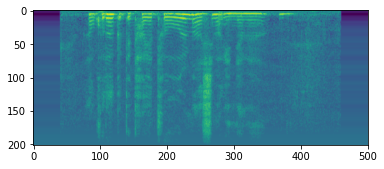

In [233]:
model.plotOriginalImage(dataset[0][0][0])

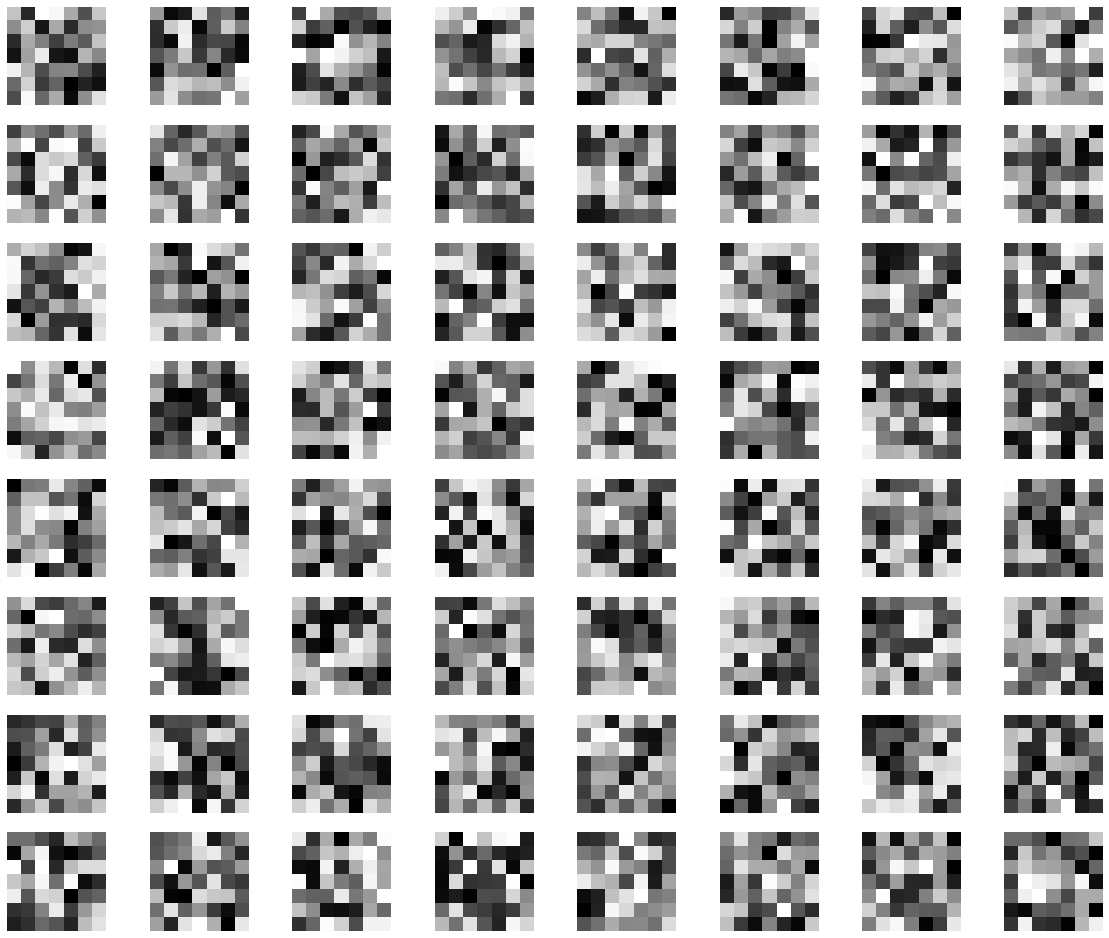

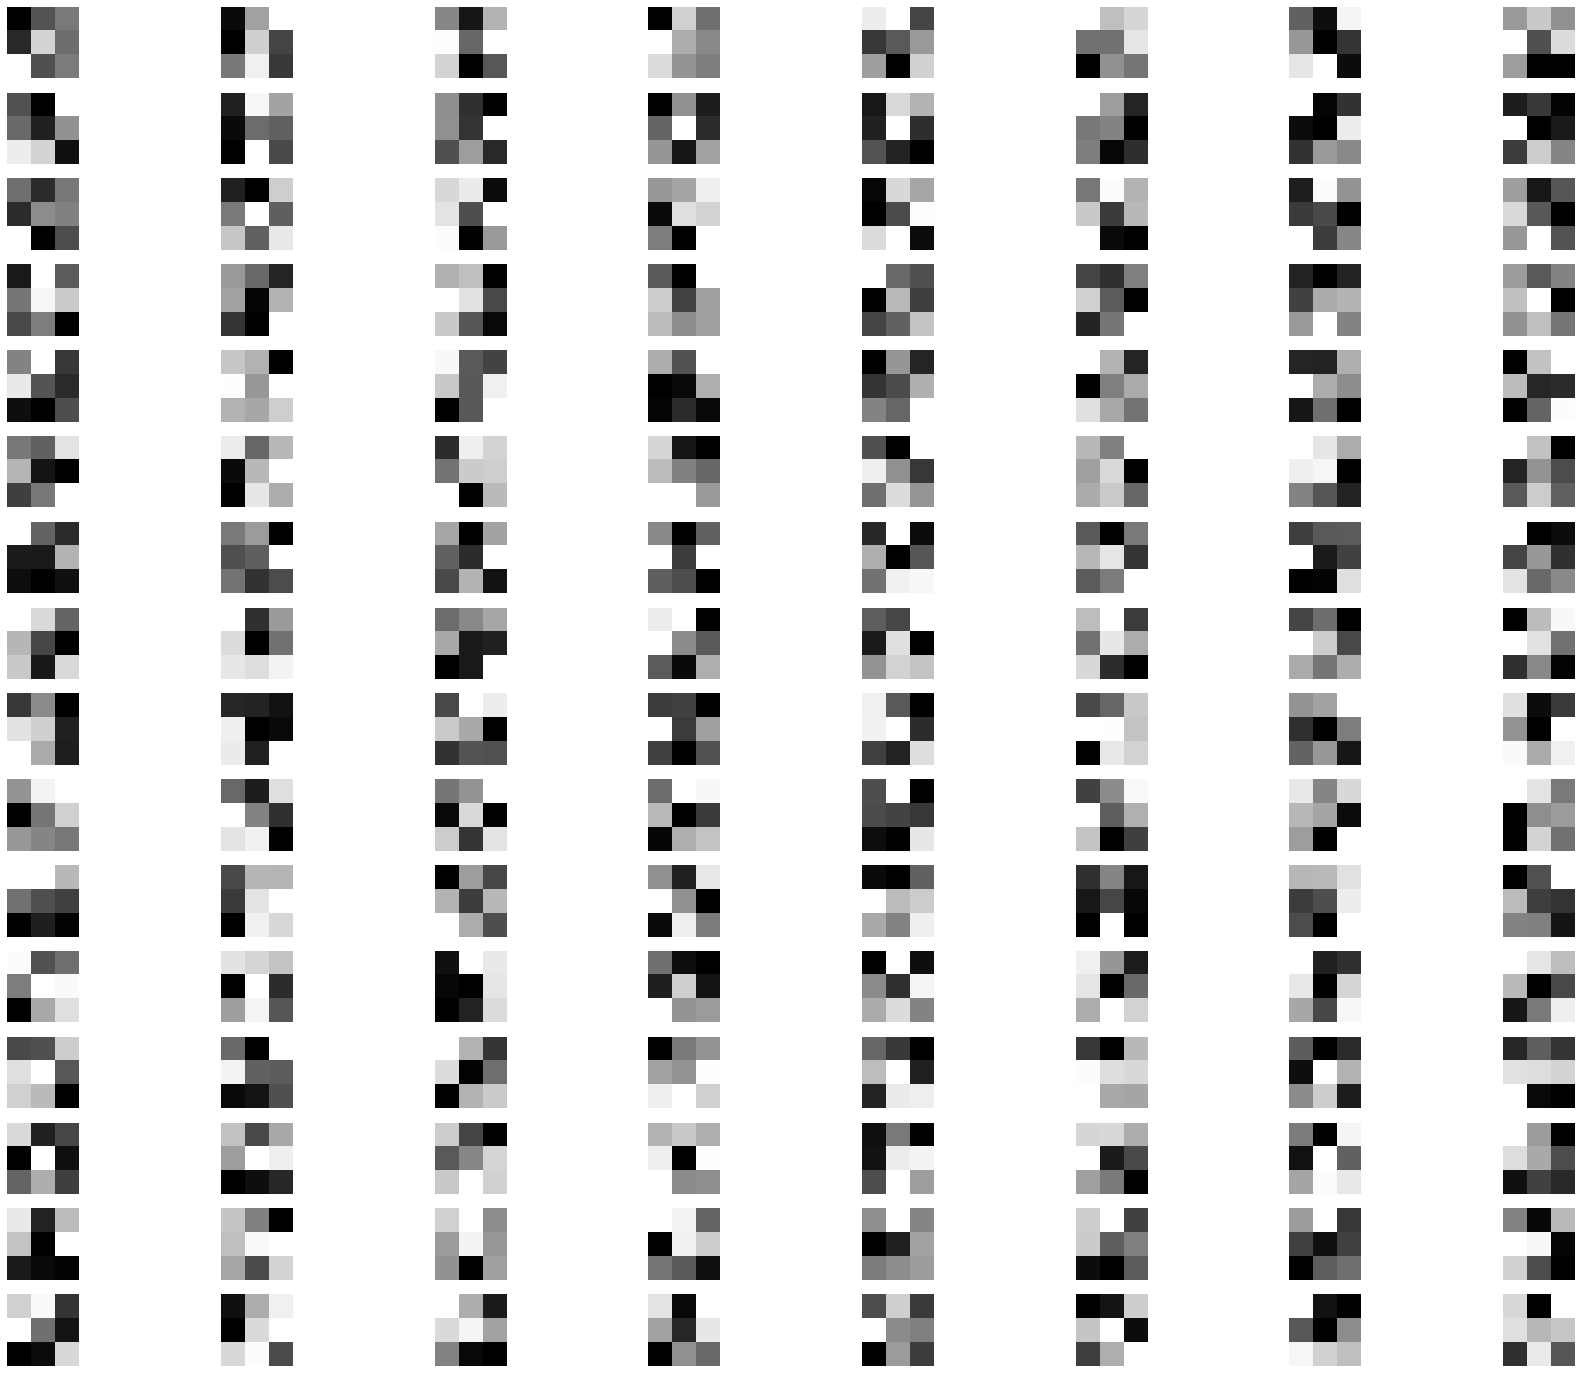

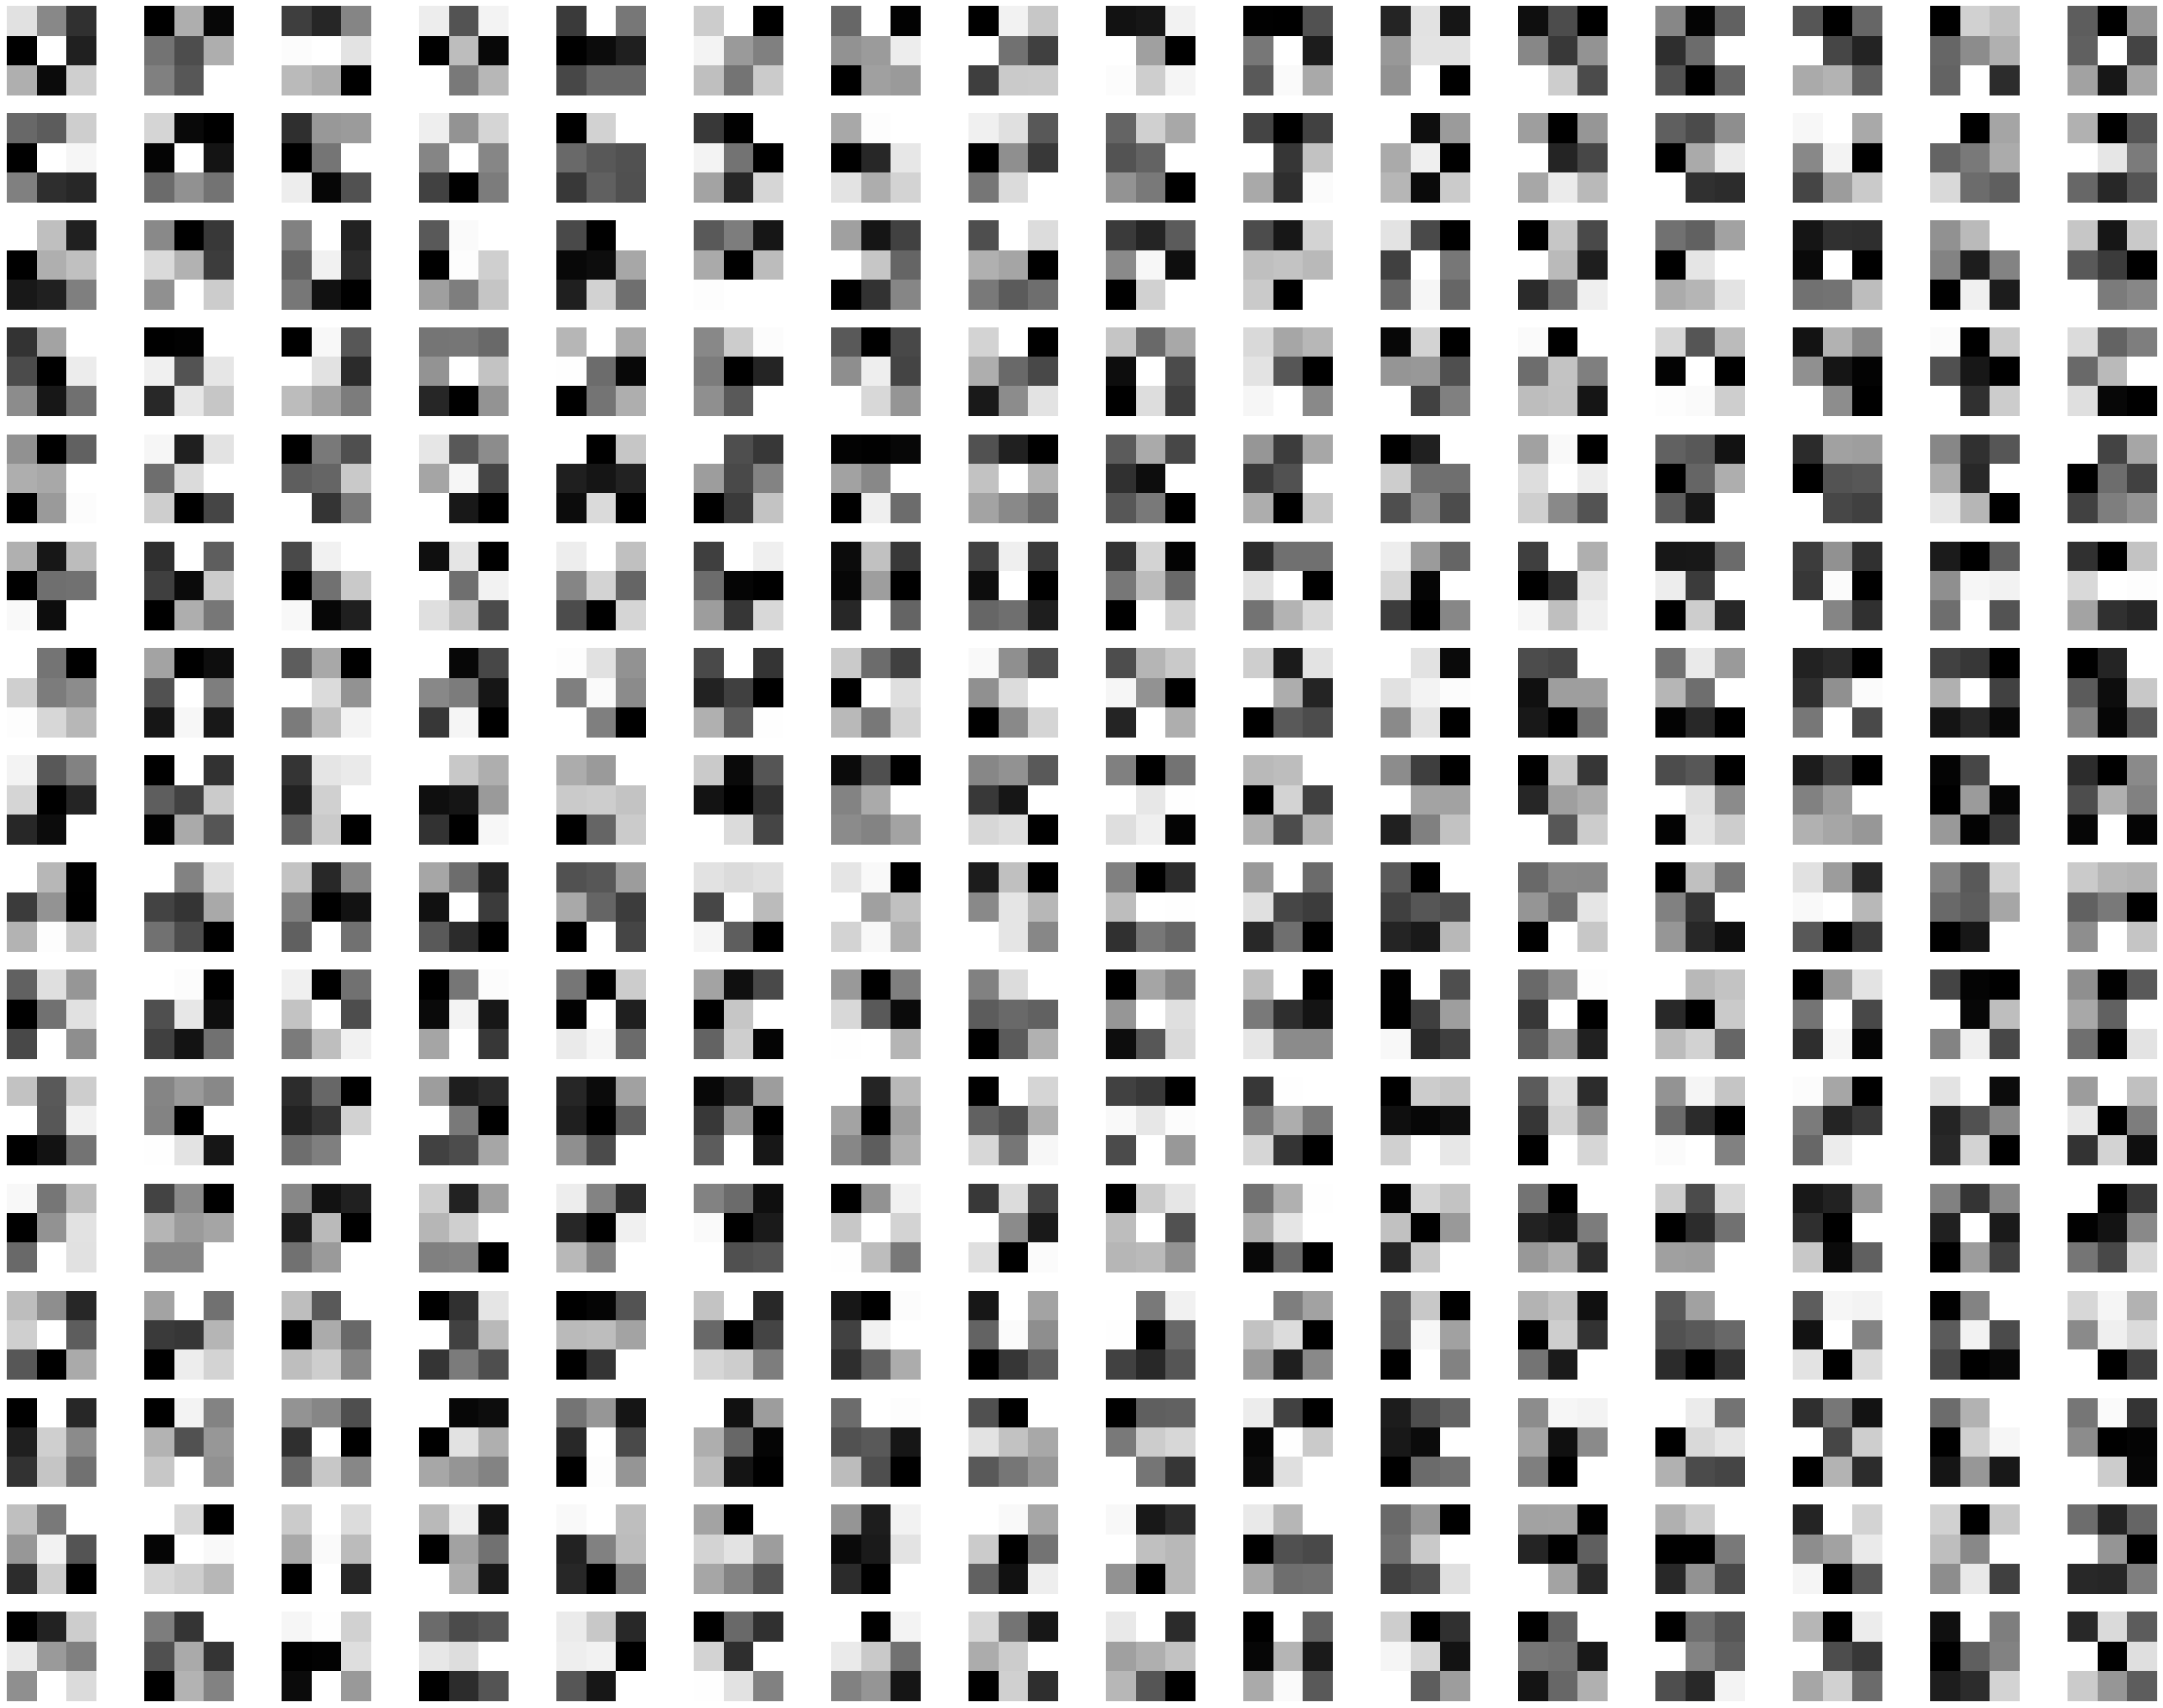

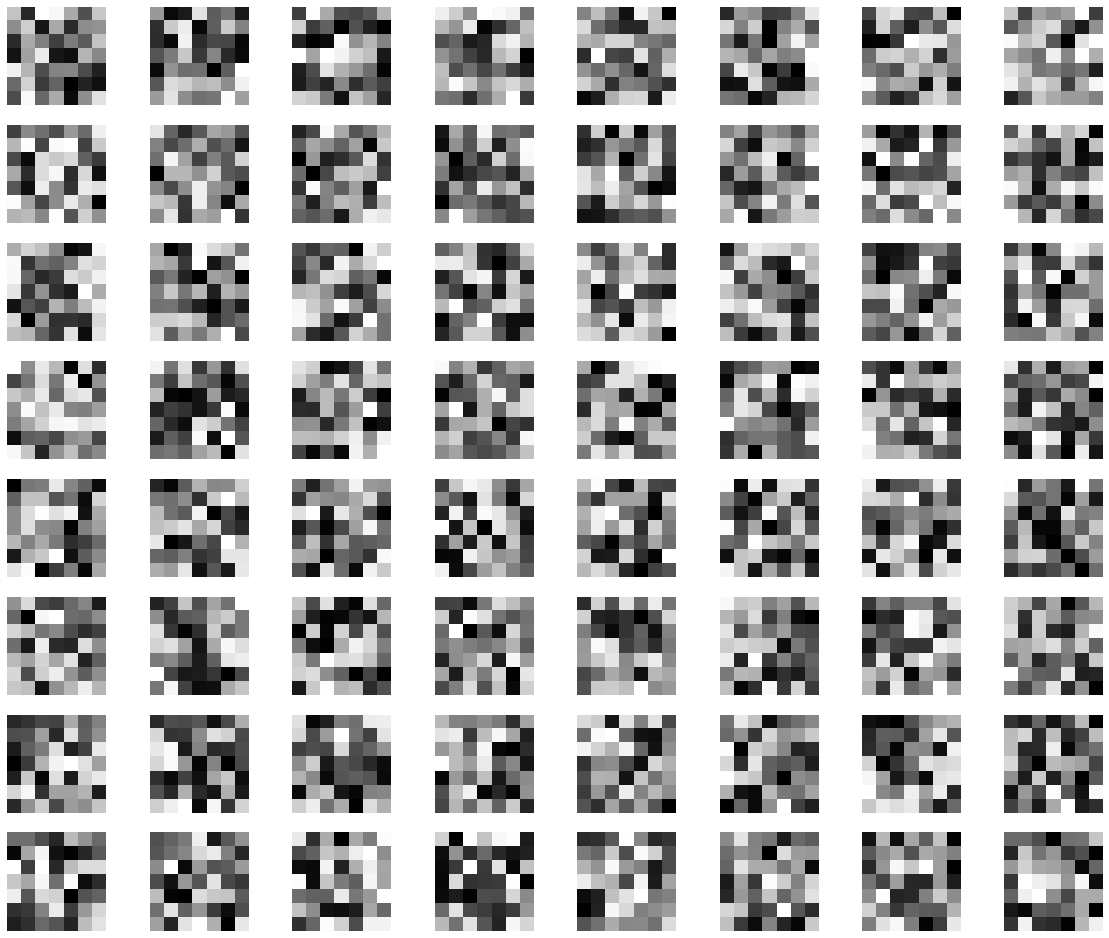

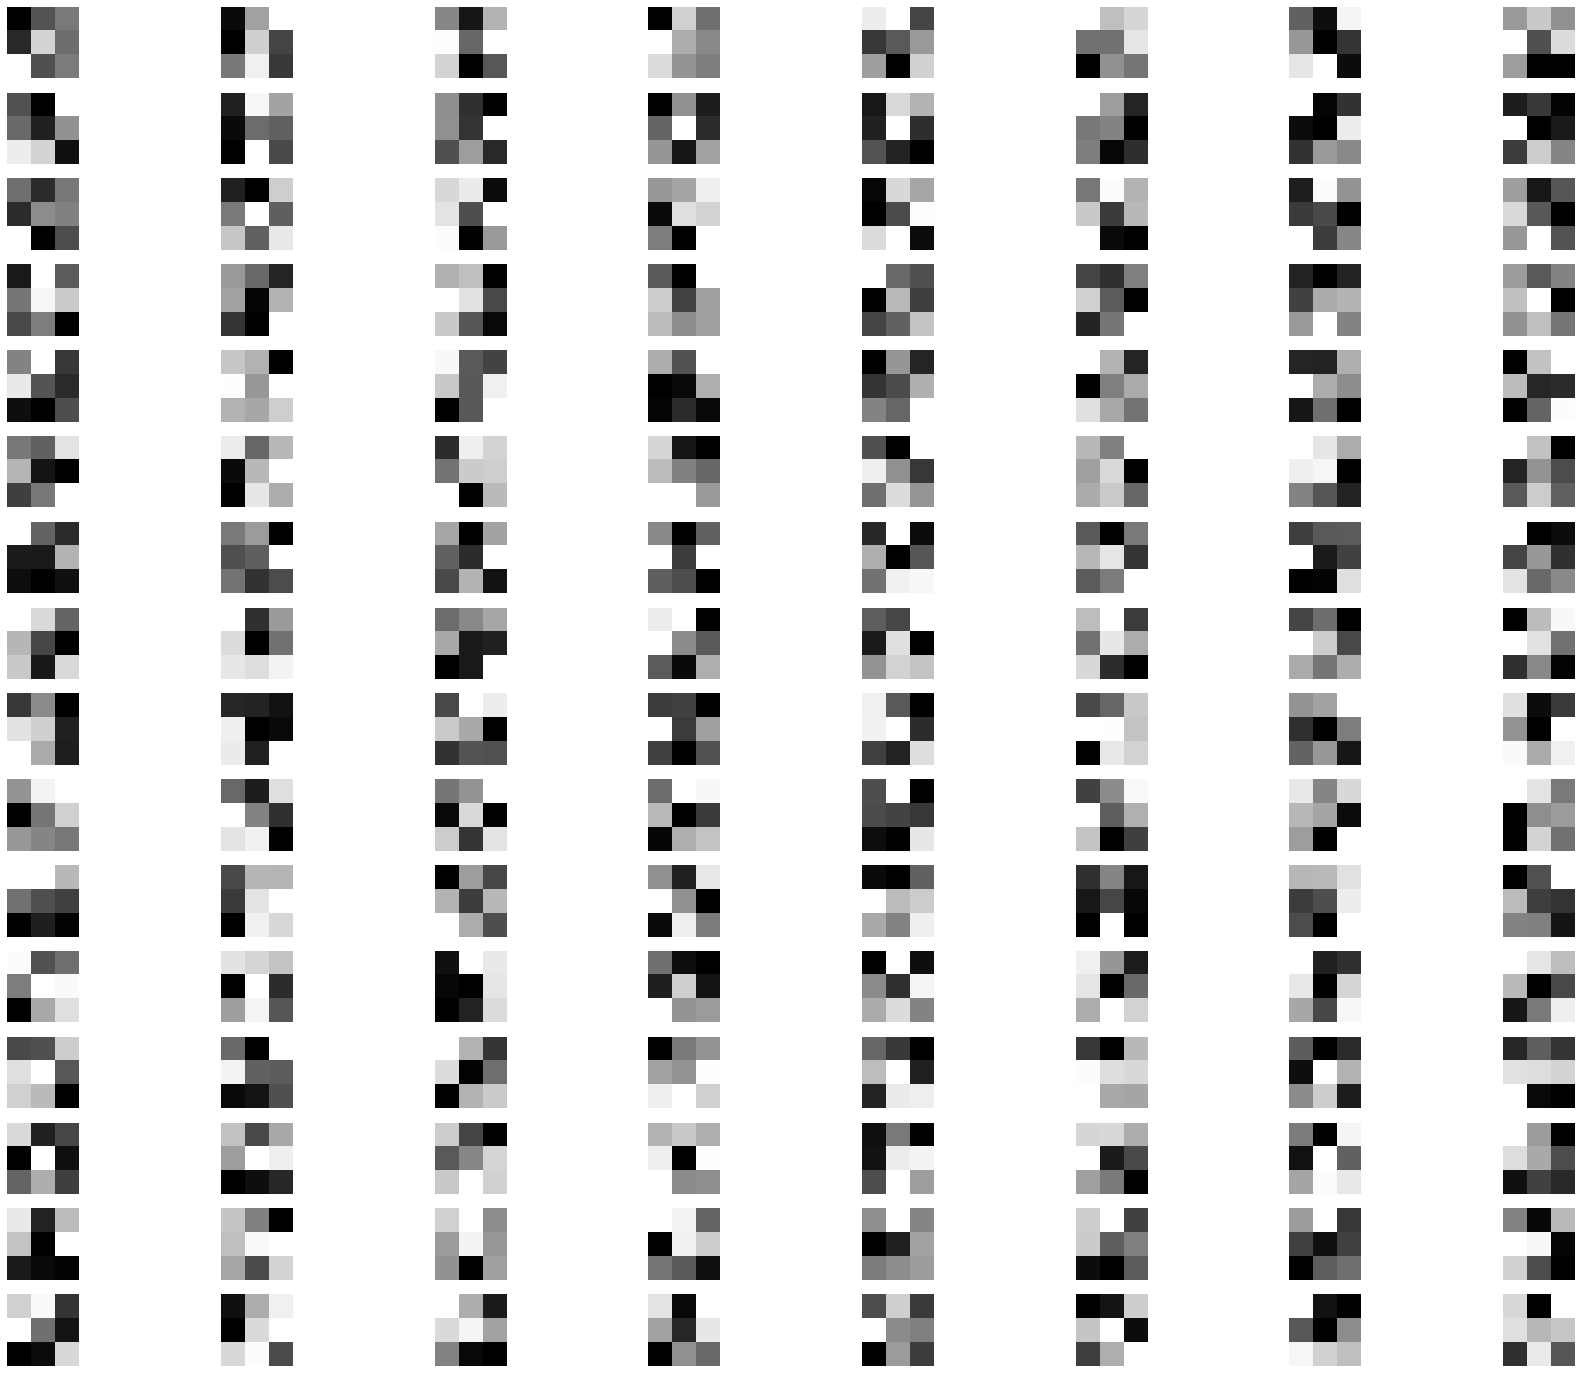

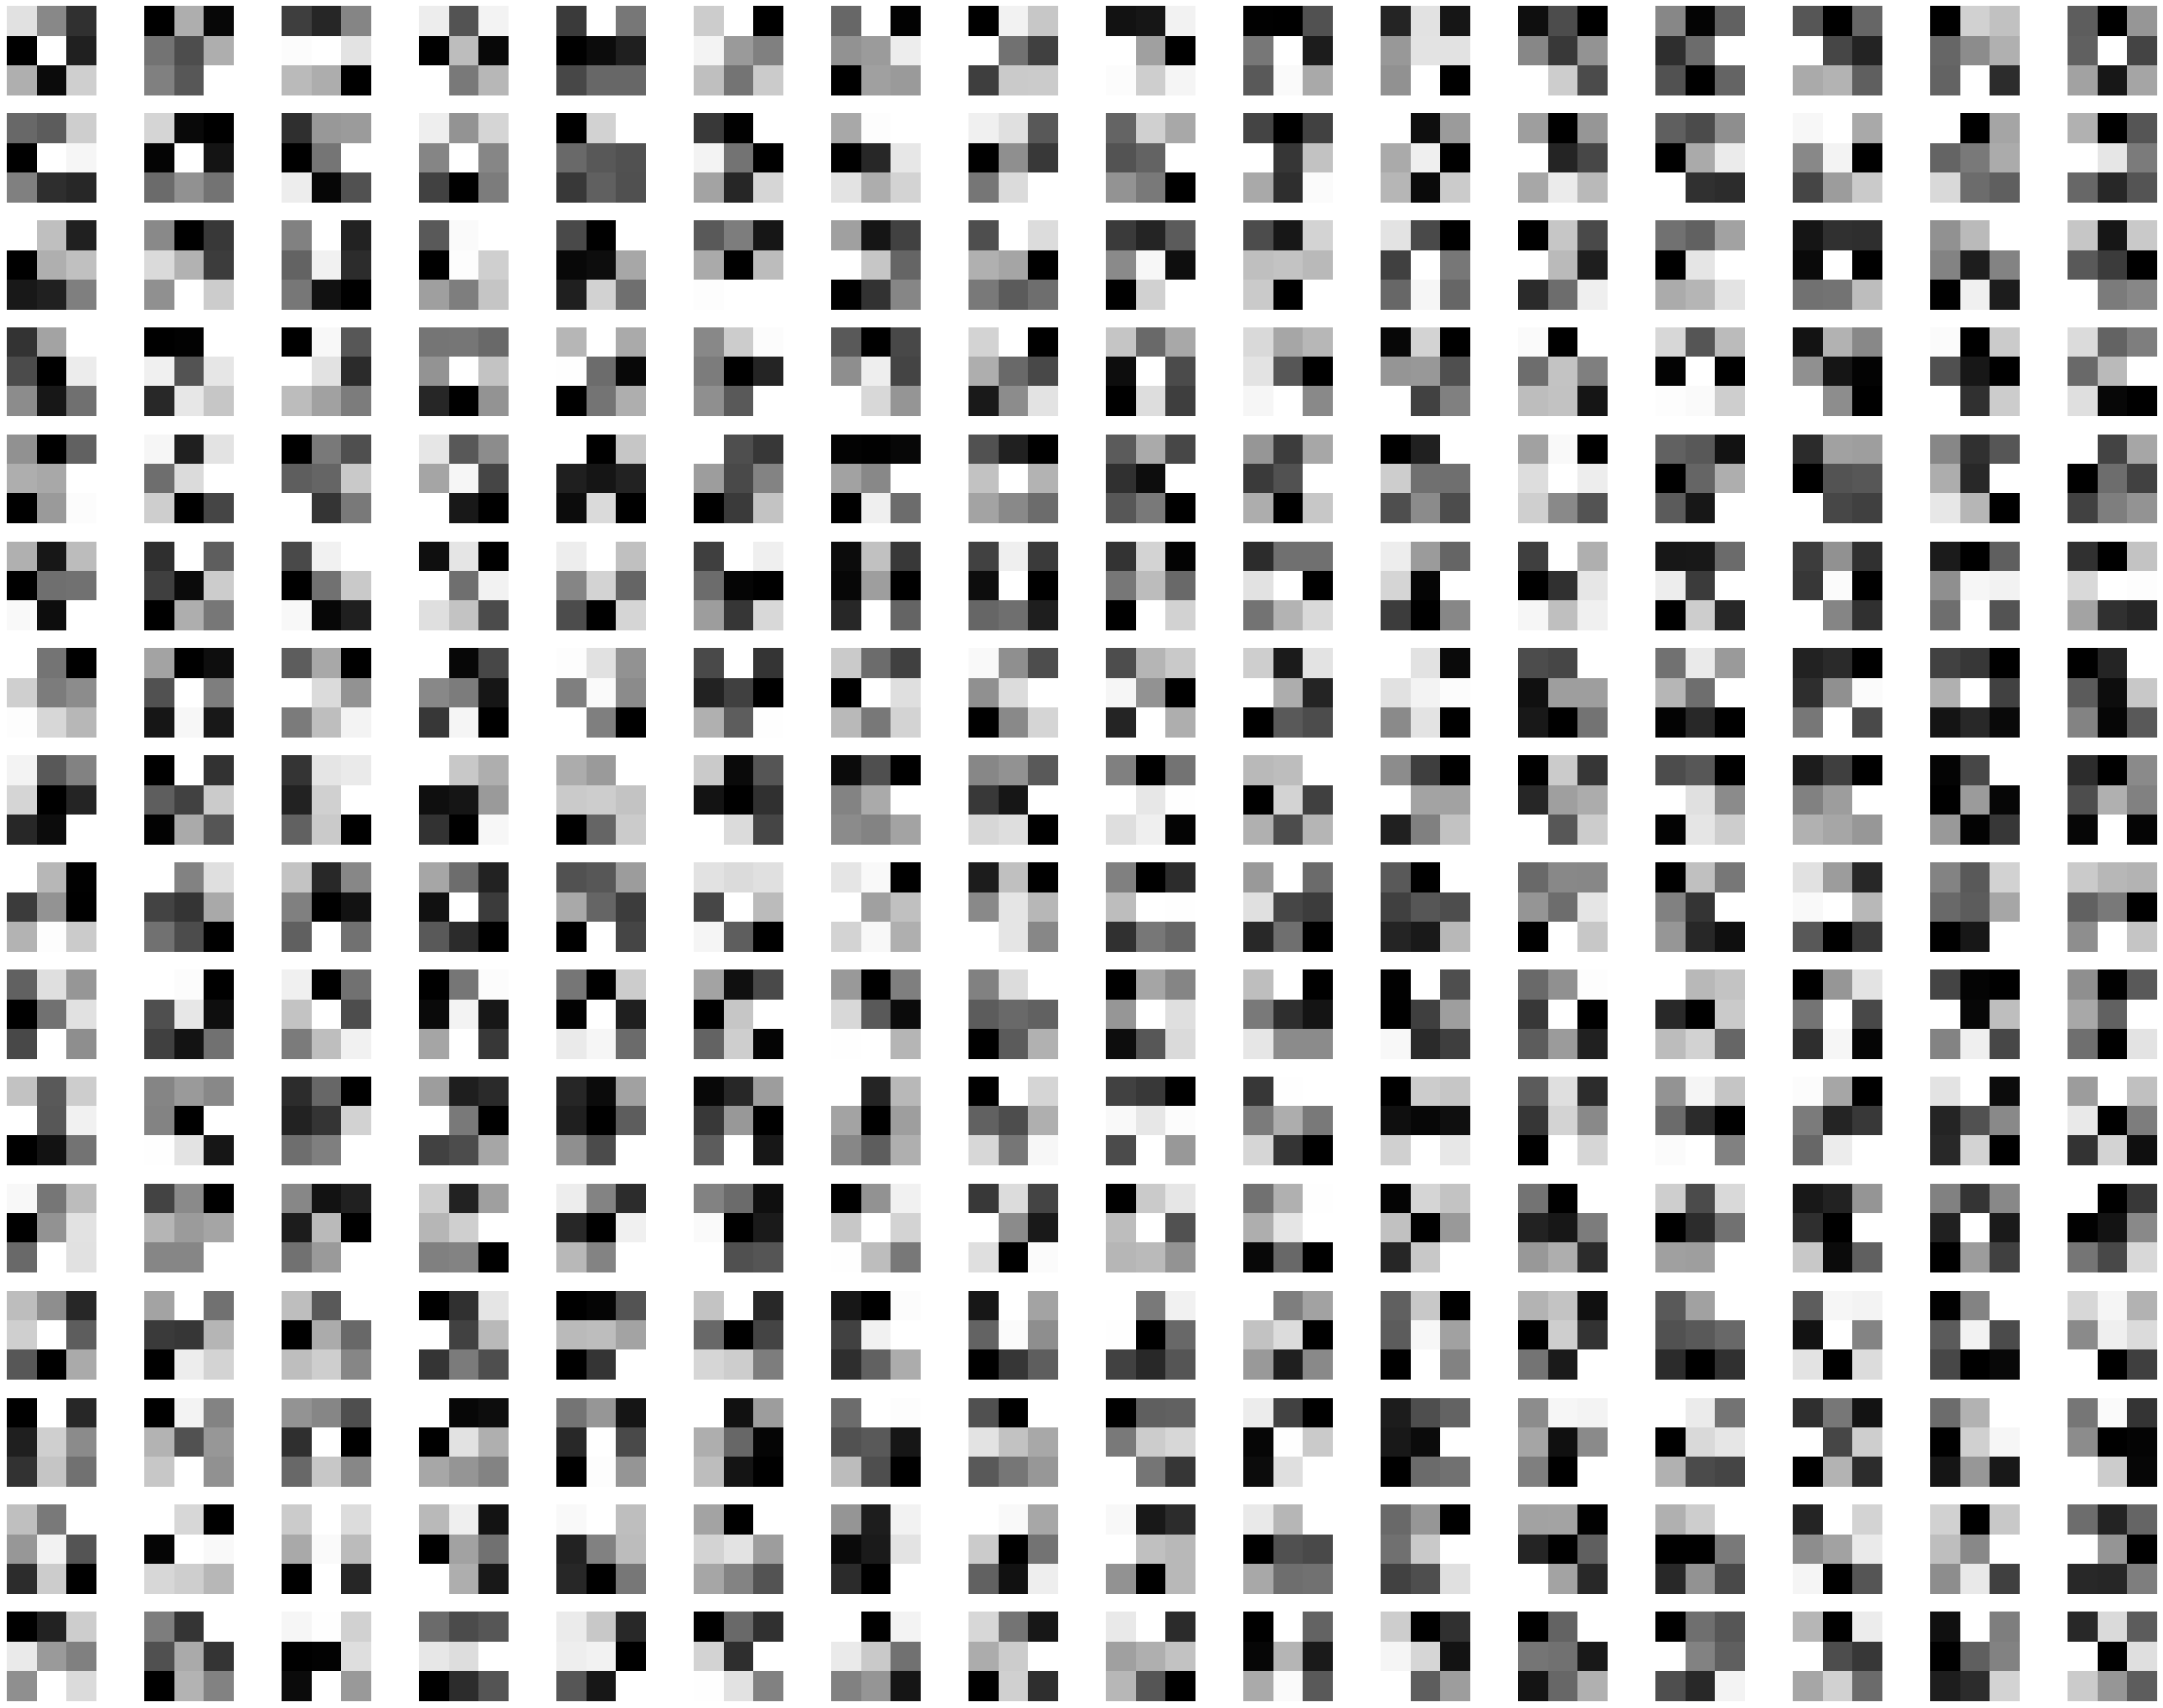

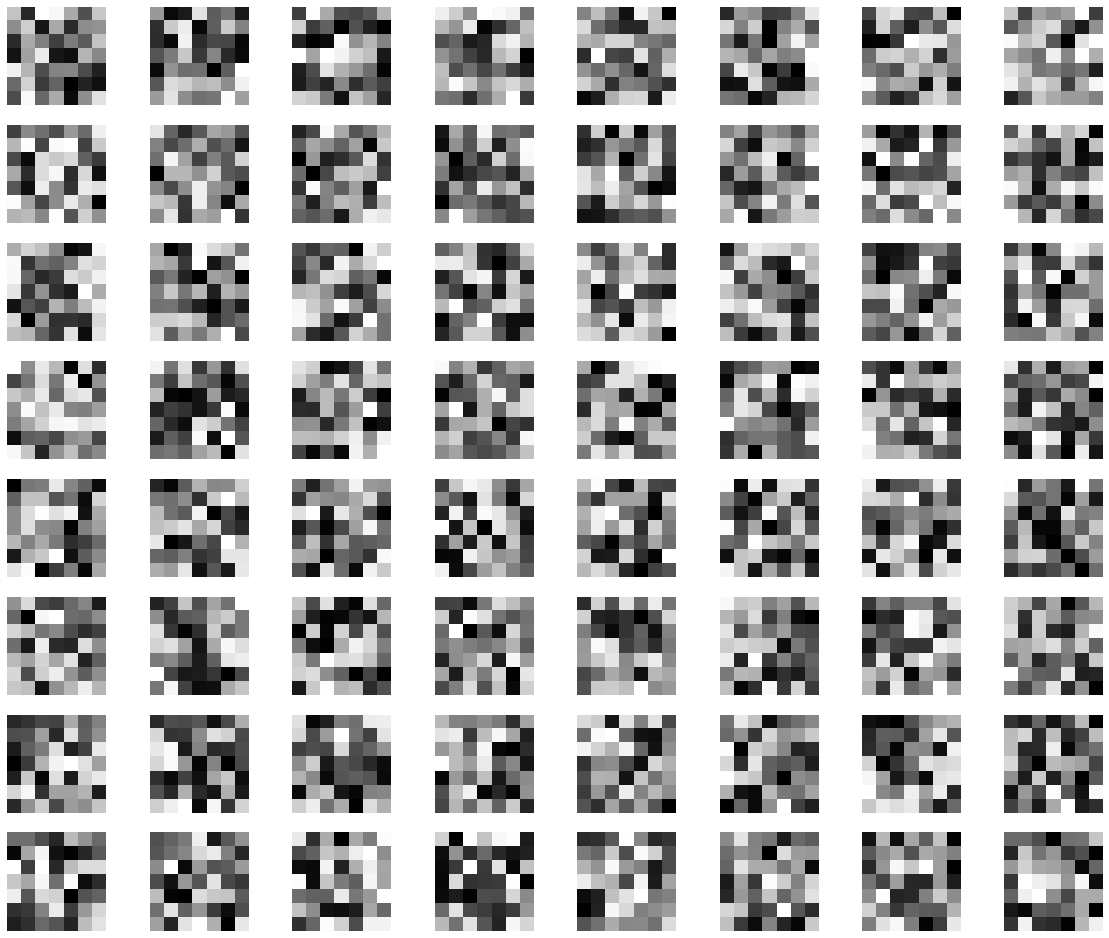

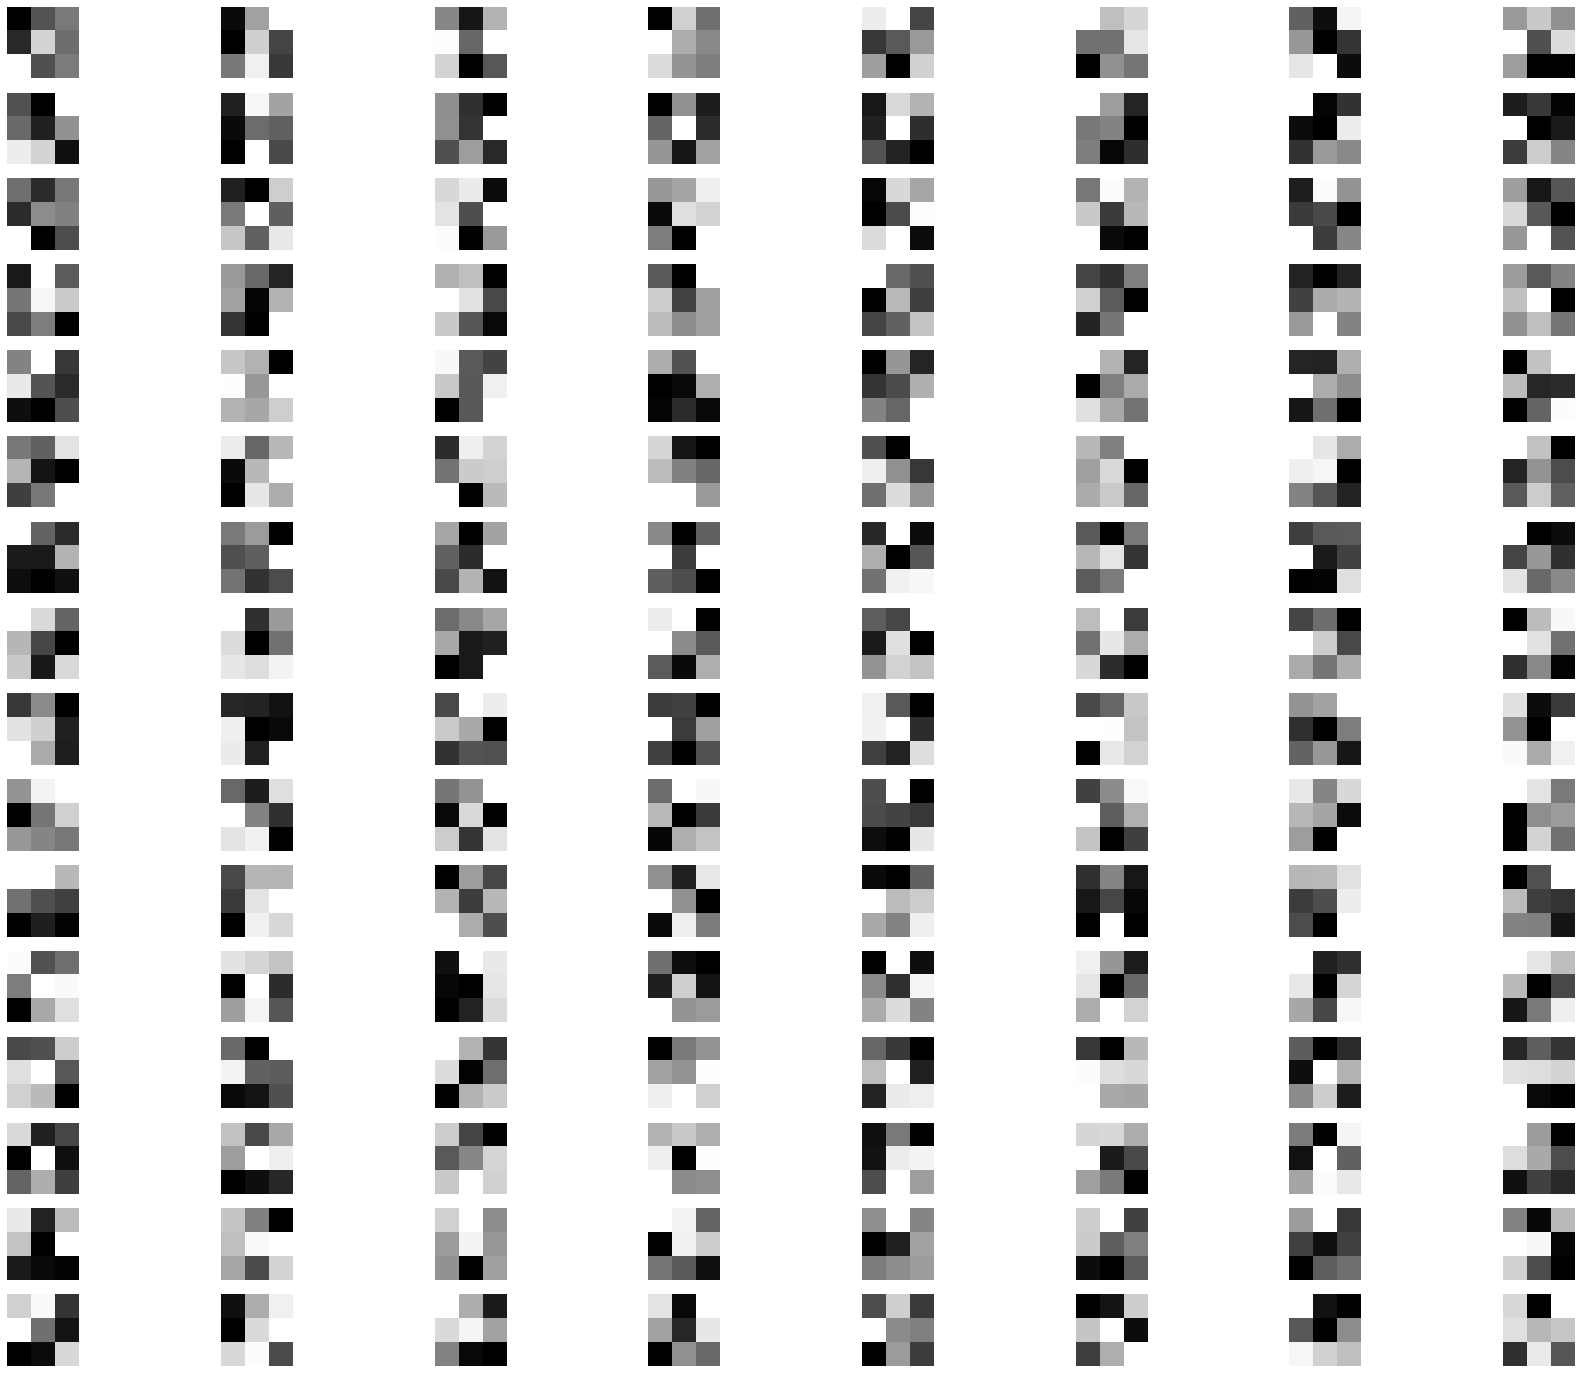

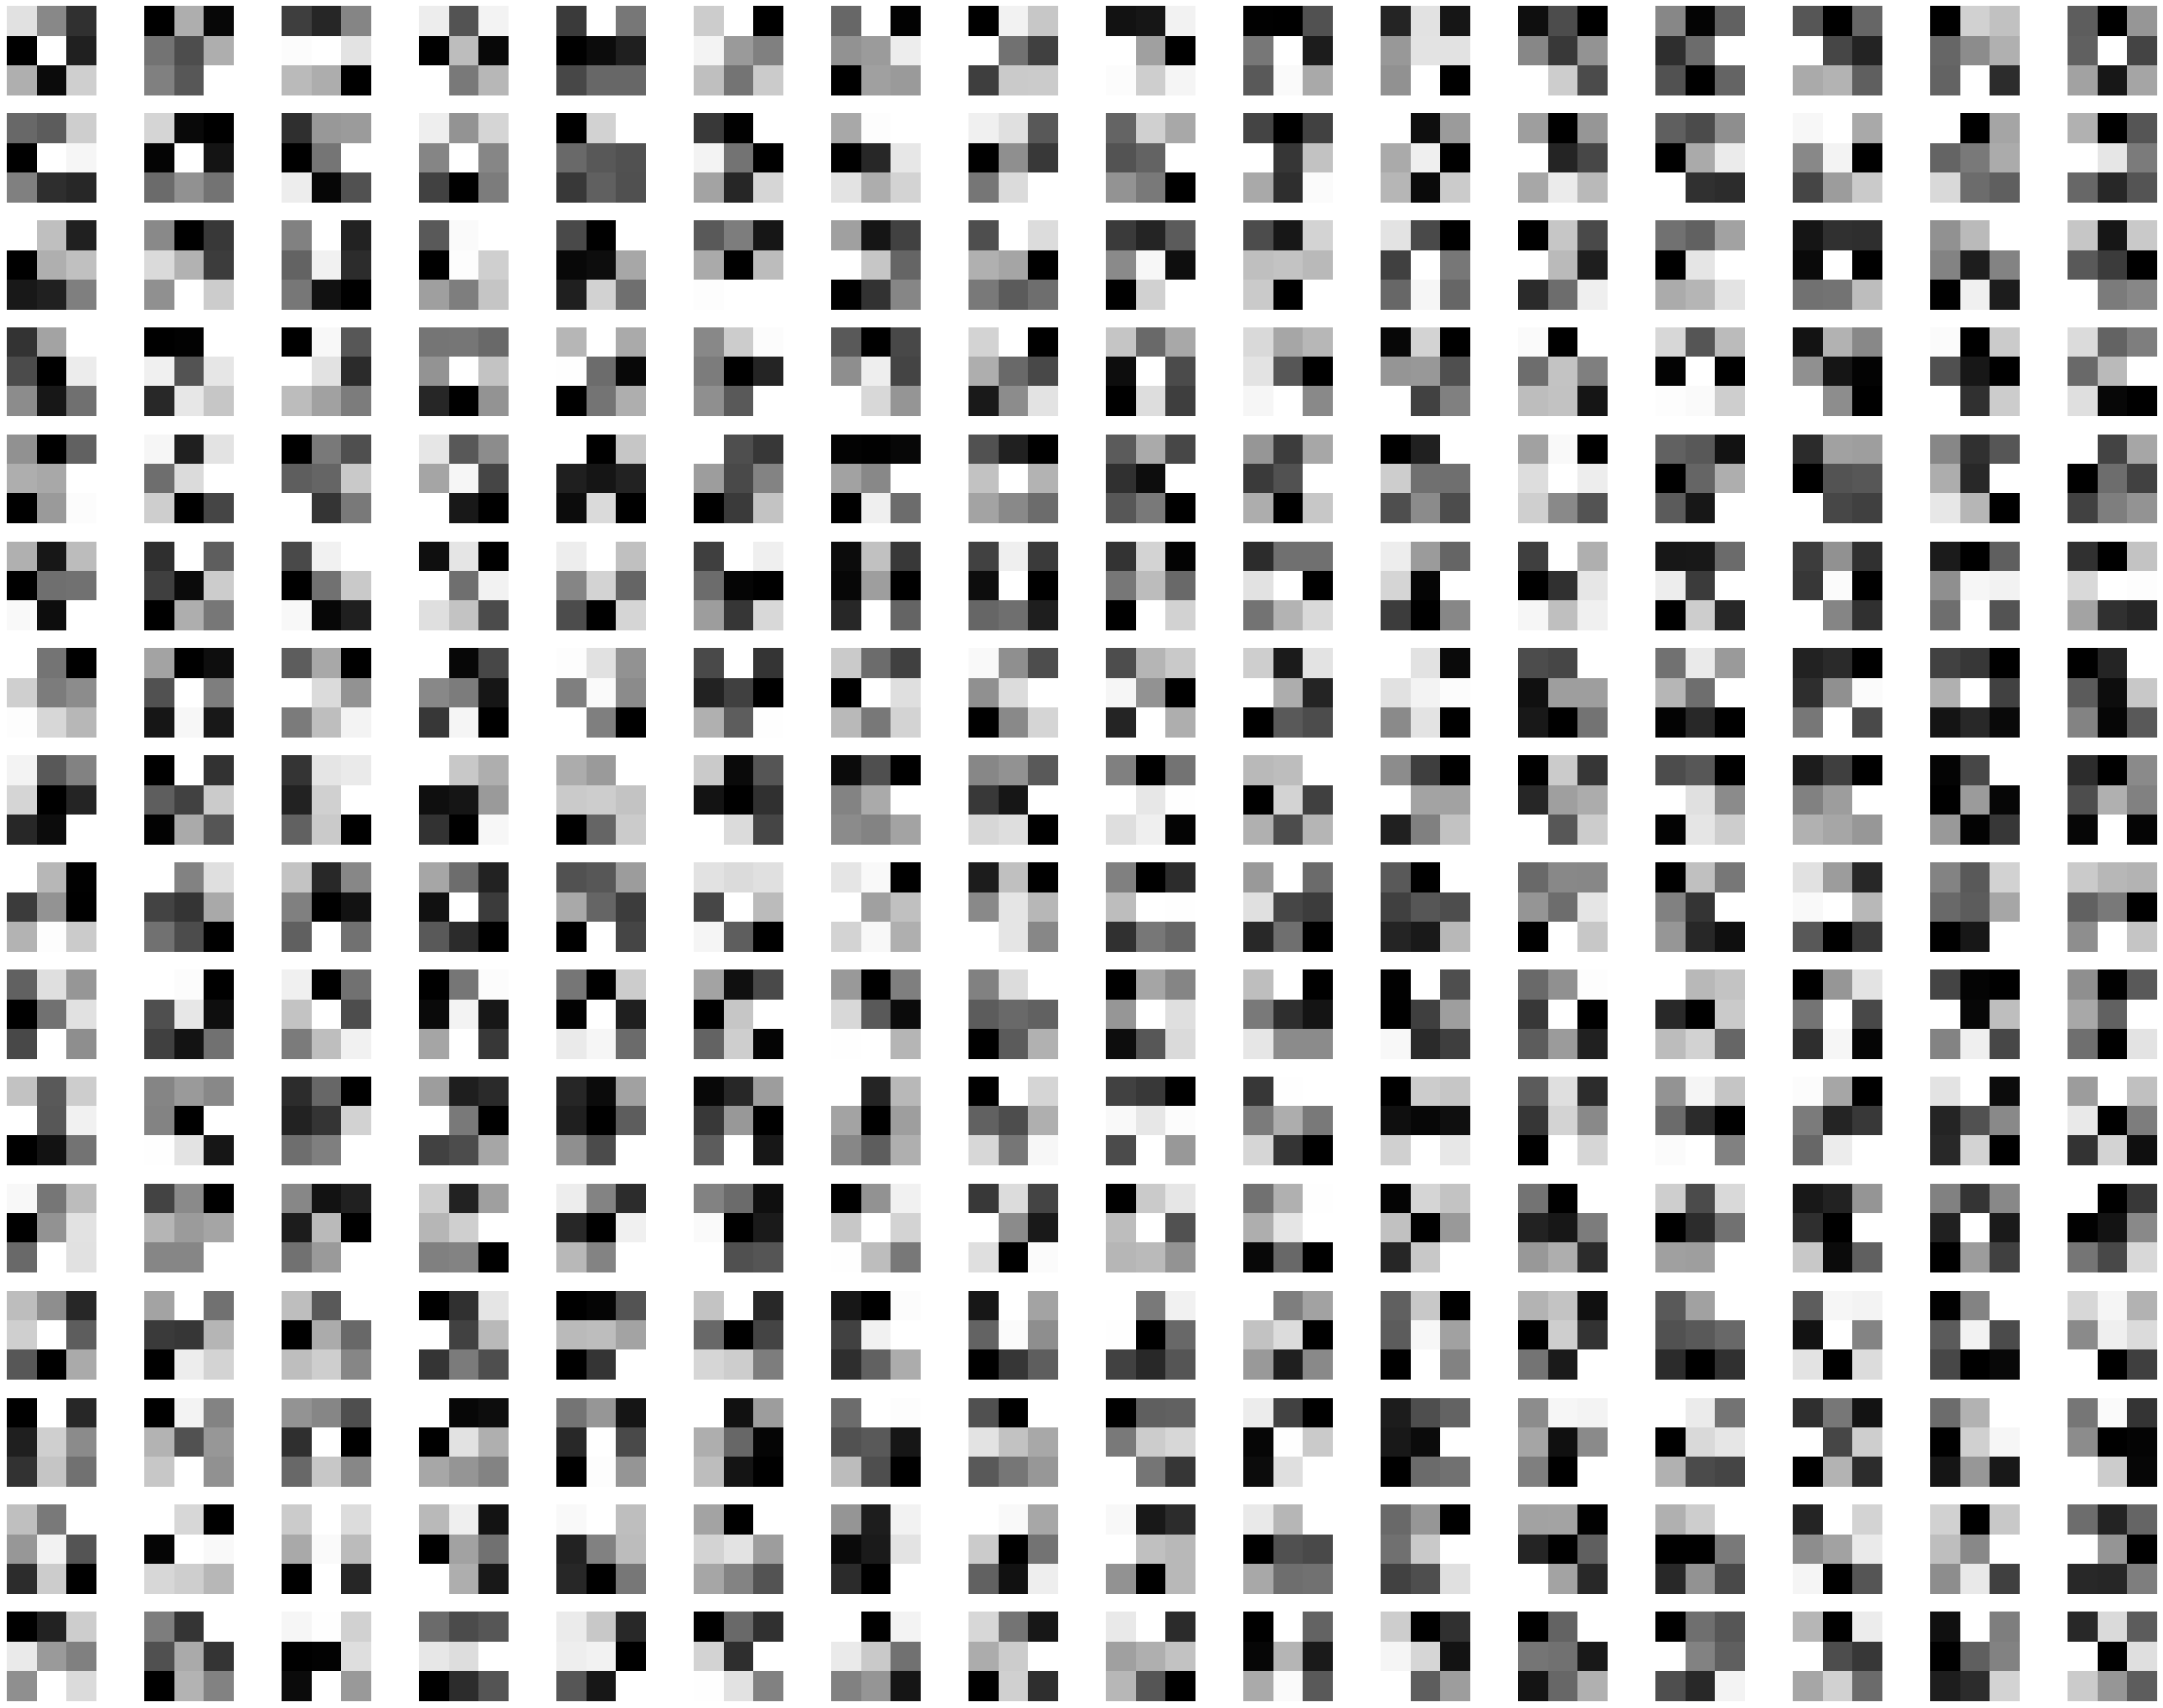

In [234]:
model.plotFilter(where='first', data_type='spec', when='before_train')
model.plotFilter(where='middle', data_type='mfcc', when='before_train')
model.plotFilter(where='last', data_type='chroma', when='before_train')
model.plotFilter(where='first', data_type='spec', when='before_train')
model.plotFilter(where='middle', data_type='mfcc', when='before_train')
model.plotFilter(where='last', data_type='chroma', when='before_train')
model.plotFilter(where='first', data_type='spec', when='before_train')
model.plotFilter(where='middle', data_type='mfcc', when='before_train')
model.plotFilter(where='last', data_type='chroma', when='before_train')

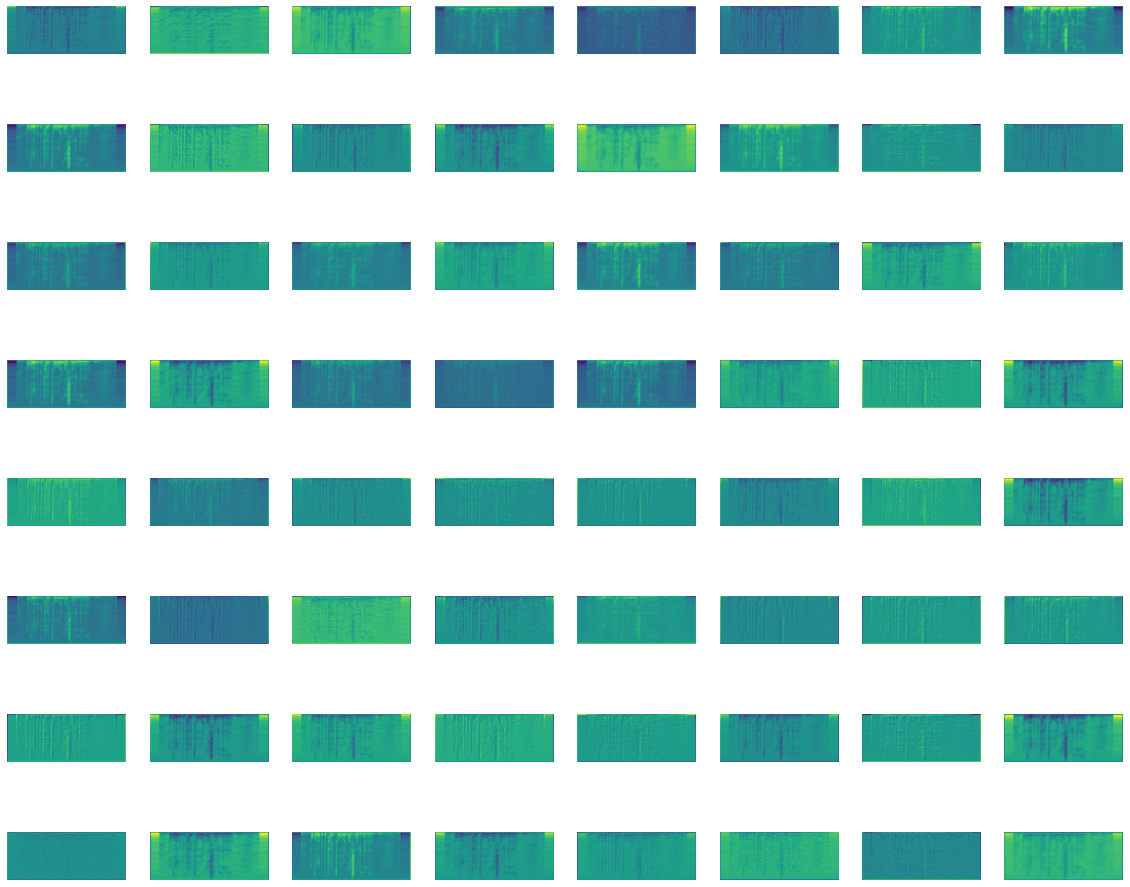

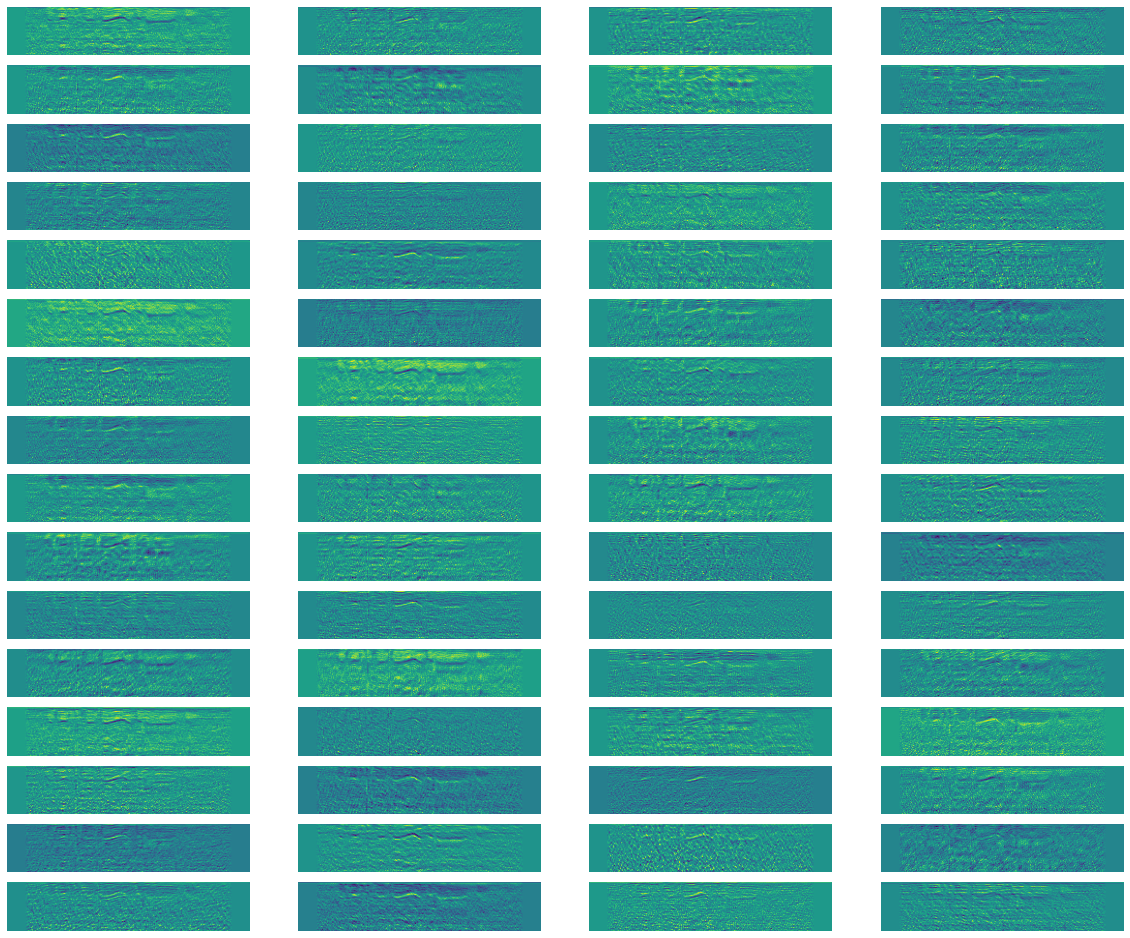

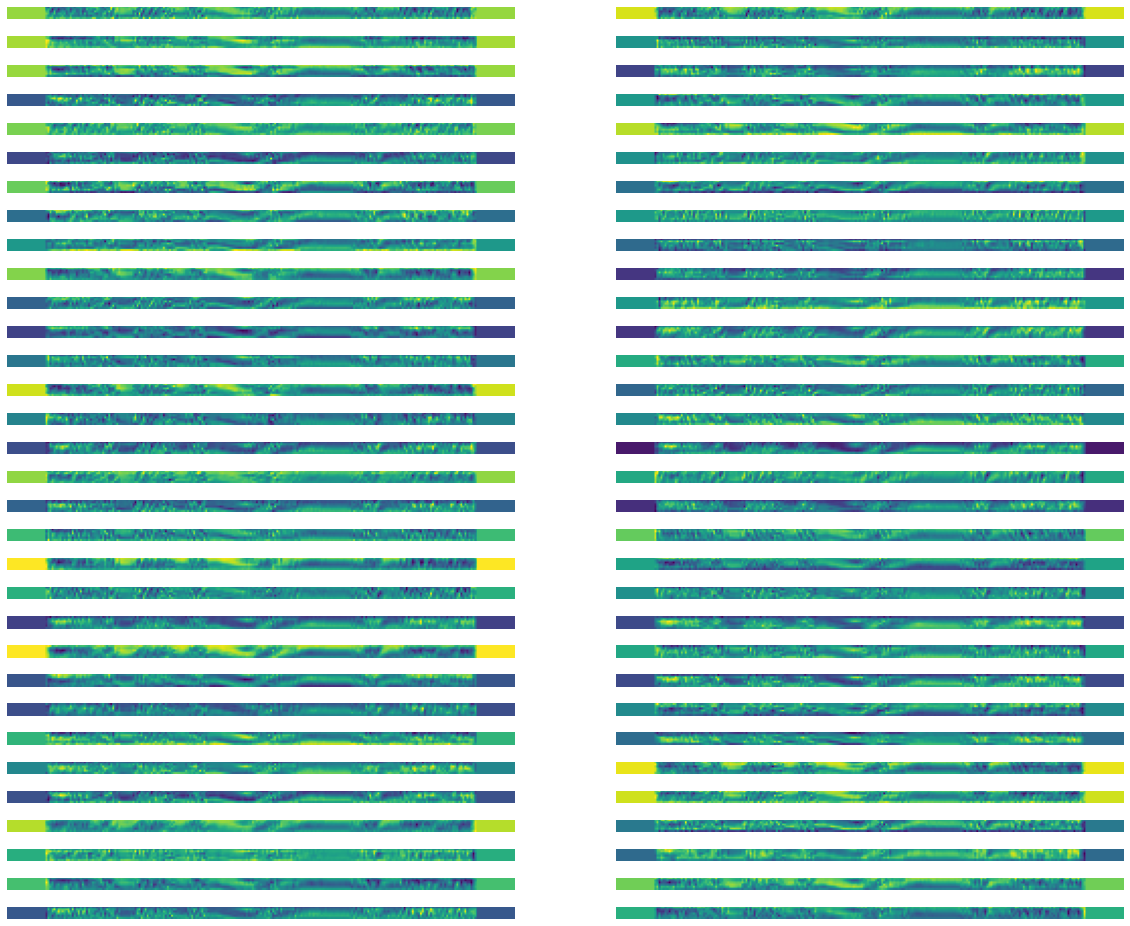

In [235]:
model.plotFeatureMap(dataset[0][0][0], data_type='spec', when='before_train')
model.plotFeatureMap(dataset[0][0][1], data_type='mfcc', when='before_train')
model.plotFeatureMap(dataset[0][0][2], data_type='chroma', when='before_train')

In [226]:
train_size = int(len(dataset)*0.8)
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

In [228]:
model.train_(train_loader, test_loader, 0.0005, 15, device)

  0%|          | 0/12 [00:01<?, ?it/s]


KeyboardInterrupt: ignored

In [ ]:
model.plot('train_acc')
model.plot('train_loss')
model.plot('val_acc')
model.plot('val_loss')
model.plot('confusion_train')
model.plot('confusion_normalize_train')
model.plot('confusion_val')
model.plot('confusion_normalize_val')

In [ ]:
spec_weights, spec_layers, mfcc_weights, mfcc_layers, chroma_weights, chroma_layers = model.extractConvLayer()

In [ ]:
model.plotFilter(where='first', data_type='spec', when='after_train')
model.plotFilter(where='middle', data_type='mfcc', when='after_train')
model.plotFilter(where='last', data_type='chroma', when='after_train')
model.plotFilter(where='first', data_type='spec', when='after_train')
model.plotFilter(where='middle', data_type='mfcc', when='after_train')
model.plotFilter(where='last', data_type='chroma', when='after_train')
model.plotFilter(where='first', data_type='spec', when='after_train')
model.plotFilter(where='middle', data_type='mfcc', when='after_train')
model.plotFilter(where='last', data_type='chroma', when='after_train')

In [ ]:
model.plotFeatureMap(dataset[0][0][0], data_type='spec', when='after_train')
model.plotFeatureMap(dataset[0][0][1], data_type='mfcc', when='after_train')
model.plotFeatureMap(dataset[0][0][2], data_type='chroma', when='after_train')